# SVM y Métodos Kernel

En este Notebook vamos a poner a prueba el algoritmo de SVMs, tanto en problemas de clasificación como de regresión. Adicionalmente, se analizará el funcionamiento de otros métodos que utilizan el concepto de [Kernel](https://en.wikipedia.org/wiki/Kernel_method). 

## Contenidos

1. SVMs en problemas de clasificación
    1. Ejemplos sintéticos
    2. Ejemplo realista ([Pima Indian Diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database))
    3. Recursive Feature Elimination (RFE)
2. SVMs en problemas de regresión
    1. Ejemplo sintético
    2. Ejemplo realista ([House Sales in King COunty, USA](https://www.kaggle.com/harlfoxem/housesalesprediction))
3. Otros métodos Kernel
    1. Ridge Kernel Regression
    2. Kernel PCA

## Librerías y funciones

Lo primero es cargar las librerías y funciones necesarias.

In [1]:
# cargamos librerías necesarias
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt # para dibujar
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

In [2]:
# definimos una función para representar el resultado del ajuste
def plot_decision_boundary_svm(X,y,h,model):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .05  # step size in the mesh
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Zd = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Zd = Zd.reshape(xx.shape)
    
    Zp = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1] 
    Zp = Zp.reshape(xx.shape)
    
    # Error de clasificación
    ypred = model.predict(X)
    acc = accuracy_score(y,ypred)
    
    plt.figure(1, figsize=(12, 5))
    
    plt.subplot(1,2,1)
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,c='k', facecolors='none')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.contour(xx, yy, Zd, colors=['k', 'k', 'k'],linestyles=['--', '-', '--'], levels=[-1, 0, 1])
    plt.contourf(xx, yy, Zd>0,cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'FRONTERA DECISION\n Acc: %0.2g' % acc
    plt.title(msg)
        
    plt.subplot(1,2,2)
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,c='k', facecolors='none')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.contour(xx, yy, Zd, colors=['k', 'k', 'k'],linestyles=['--', '-', '--'], levels=[-1, 0, 1])
    plt.contourf(xx, yy, Zp,cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'PROBABILIDAD\n Acc: %0.2g' % acc
    plt.title(msg)
    
    plt.tight_layout()
    plt.show()

# 1. SVMs en problemas de clasificación

Comenzaremos analizando las máquinas de vectores soporte en clasificación, en ocasiones denominadas *Support Vector Classifiers*. Como hemos hecho en notebooks anteriores, primero probamos sobre ejemplos sintéticos

## 1.1 Ejemplos sintéticos

Cargamos y representamos nuestros ejemplos.

In [3]:
# ejemplo1
ejemplo1 = pd.read_csv("./data/ex2data1.txt", sep=",", header=None, names=['x1', 'x2','label'])

# ejemplo2
ejemplo2 = pd.read_csv("./data/ex2data2.txt", sep=",", header=None, names=['x1', 'x2','label'])

# ejemplo 3: Problema XOR 
np.random.seed(0)

# -- parameters
N     = 800
mu    = 1.5      # Cambia este valor
sigma = 1      # Cambia este valor

# variables auxiliares
unos = np.ones(int(N/4))
random4 = sigma*np.random.randn(int(N/4),1)
random2 = sigma*np.random.randn(int(N/2),1)

# -- features
y3 = np.concatenate([-1*unos,       unos,          unos,         -1*unos]) 
X1 = np.concatenate([-mu + random4, mu + random4, -mu + random4, mu + random4])
X2 = np.concatenate([+mu + random2,               -mu + random2])
X3 = np.hstack((X1,X2))

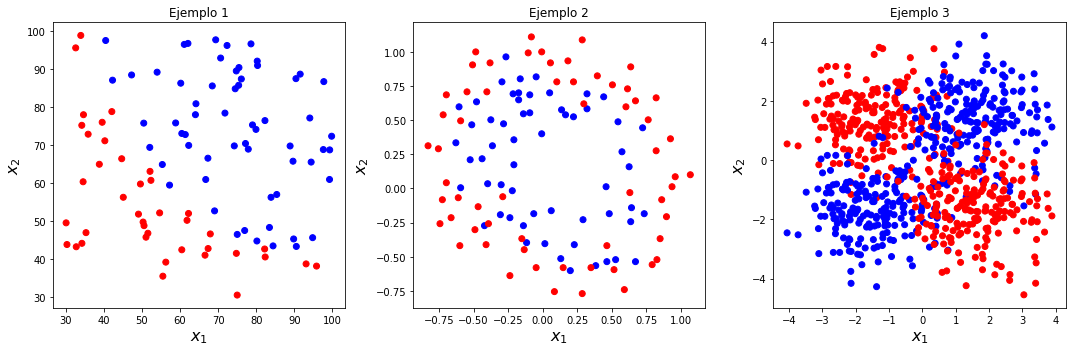

In [4]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(ejemplo1['x1'], ejemplo1['x2'], c=ejemplo1['label'], cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Ejemplo 1')

plt.subplot(1,3,2)
plt.scatter(ejemplo2['x1'], ejemplo2['x2'], c=ejemplo2['label'], cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Ejemplo 2')

plt.subplot(1,3,3)
plt.scatter(X3[:,0], X3[:,1], c=y3, cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Ejemplo 3')

plt.tight_layout()
plt.show()

### Ejemplo 1

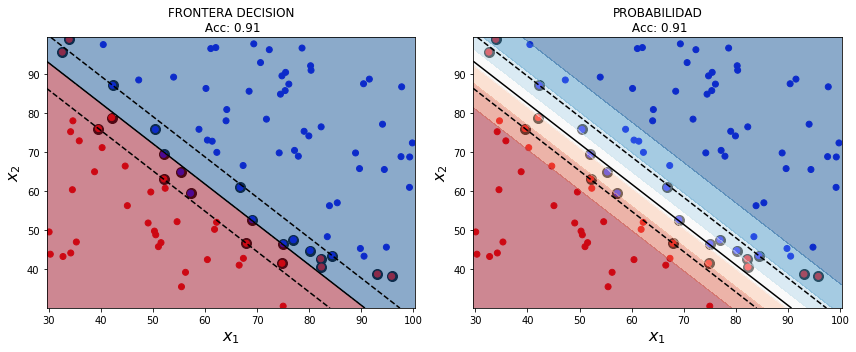

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Ejemplo 1
# preparamos los datos
data1 = ejemplo1.values
X1 = data1[:,0:2]
y1 = data1[:,-1]

# creamos el modelo y ajustamos
svmModel1= SVC(kernel='linear', probability = True)
svmModel1.fit(X1,y1)

plot_decision_boundary_svm(X1,y1,0.05,svmModel1)

Donde hemos resaltado los **vectores soporte**, la **frontera de separación** y el **margen**. 

Como el problema no es linealmente separable, observamos errores de clasificación que caen tanto dentro del margen, como al otro lado de la frontera de separación correspondiente. 

Sabemos que podemos permitir ciertos errores dentro del margen, y los penalizamos con un coste $C$. 

* Si tenemos un valor elevado del coste $C$, estaremos penalizando mucho los errores, y por tanto se obtienen fronteras más ajustadas (mayor complejidad, mayor riesgo de overfitting, potenciales mejores prestaciones). 

* De otro lado, si tenemos un valor pequeño del coste $C$, no daremos mucha importancia a los errores, y por tanto se obtienen fronteras menos ajustadas (menor complejidad, menor riesgo de overfitting, potenciales peores prestaciones). 

Se puede modificar el coste $C$ mediante el parámetro de mismo nombre en scikit-learn. Por defecto, $C=1$.

In [ ]:
svmModel1= SVC(kernel='linear',probability=True,C = 0.0001) # PIENSA ANTES COMO SERÁ EL RESULTADO!
svmModel1.fit(X1,y1)

plot_decision_boundary_svm(X1,y1,0.05,svmModel1)

In [ ]:
svmModel1= SVC(kernel='linear',probability=True,C = 1e5) # PIENSA ANTES COMO SERÁ EL RESULTADO!
svmModel1.fit(X1,y1)

plot_decision_boundary_svm(X1,y1,0.05,svmModel1)

### Ejemplos 2 y 3

Comenzamos por el ejemplo 2.

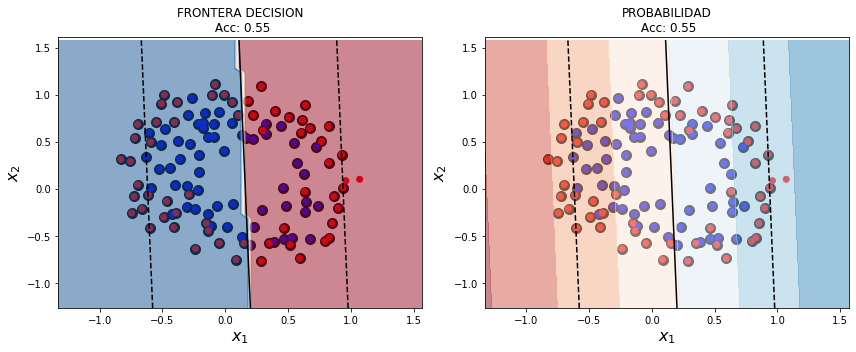

In [8]:
# preparamos los datos
data2 = ejemplo2.values
X2 = data2[:,0:2]
y2 = data2[:,-1]

# creamos el modelo
svmModel2= SVC(kernel='linear',probability=True)
svmModel2.fit(X2,y2)

plot_decision_boundary_svm(X2,y2,0.05,svmModel2)

Como podemos comprobar, un kernel lineal no nos sirve para generar una frontera de separación no lineal, así que tenemos que utilizar otros kernels.

<div class = "alert alert-success">
**EJERCICIO:** Echa un vistazo a la documentación para conocer cómo entrenar un algoritmo [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) con diferentes Kernels. Prueba entonces distintos Kernels con distintos valores de sus parámetros libres
</div>

In [ ]:
# RBF


In [ ]:
# Polinómico


<div class = "alert alert-success">
**EJERCICIO:** Entrena una SVM sobre el ejemplo 3.
</div>

In [ ]:
# Ejemplo 3


<div class = "alert alert-success">
**EJERCICIO**: Suponiendo un kernel RBD, calcule el valor óptimo de *C* y *gamma* para el ejemplo 3, ¿cuáles son las prestaciones del algoritmo para este ejemplo?
</div>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Paso 1:
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size = 0.3, shuffle = True, random_state = 0)

# Paso 2:
vectorC = np.logspace(-3, 3, 21)
vectorG = np.logspace(-5, 1, 21)

param_grid = {'C': vectorC,
              'gamma':vectorG}


# TU CODIGO AQUI



######

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.6, vmax=0.9)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('5-fold accuracy')
plt.show()

# Paso 3: mostramos prestaciones en test
Copt = grid.best_params_['C']
Gopt = grid.best_params_['gamma']

svmModel3 = SVC(kernel='rbf',gamma = Gopt, C = Copt, probability=True).fit(X_train,y_train)

print('Acc (TEST): %0.2f'%svmModel3.score(X_test,y_test))

plot_decision_boundary_svm(X_test,y_test,0.05,svmModel3)

## 1.2 Ejemplo realista

Vamos a utilizar el mismo conjunto de datos del Notebook anterior, el [Pima Indian Diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database).

In [4]:
# cargamos datos
data = pd.read_csv('./data/diabetes.csv',sep=',', decimal='.')

# preparamos los datos
features = data.columns.drop(['Outcome'])
X = data[features].values
y = data['Outcome'].values

print('Dimensionalidad datos: ', X.shape)

Dimensionalidad datos:  (768, 8)


<div class = "alert alert-success">
**EJERCICIO**: Ajuste un modelo de SVM al conjunto de datos anterior. Devuelva las prestaciones en el conjunto de test y compare con la solución de Boosted Trees.
</div>

NOTA: Best Test ACC (lo esperado) = 0.794  

In [ ]:
# paso 1


In [ ]:
# Paso 2


In [ ]:
# Paso 3


# 1.3 Recursive Feature Elimination

Sobre el conjunto anterior, vamos a implementar el algoritmo de selección de características [RFE con validación cruzada](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV), para que casi automáticamente podamos abordar una selección como la realizada en el Notebook 5, sección 1.3.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

svc = SVC(kernel='linear') # ¡sólo funciona con Kernel Lineal!

rfecv = RFECV(estimator=svc, step=1, cv=5, scoring='accuracy')
rfecv.fit(X_train, y_train)

plt.figure()
plt.xlabel("# variables")
plt.ylabel("5-fold ACC")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, '-o')
plt.show()

print('Variables seleccionadas: ',[f for f in features[rfecv.support_]] )
print('Acc (TEST): %0.2f'%rfecv.score(X_test,y_test))

# ¡No devuelve std! no podemos pintar barras de error

In [ ]:
from sklearn.feature_selection import RFE

nfeaturesOptimo = rfecv.n_features_
rfe = RFE(estimator=svc, step=1, n_features_to_select= 4).fit(X_train,y_train)
print('Variables seleccionadas: ',[f for f in features[rfe.support_]] )

print('Acc (TEST): %0.2f'%rfe.score(X_test,y_test))

<div class = "alert alert-success">
**EJERCICIO (@home)**: Utiliza un algoritmo de Random Forest para la selección de características
</div>

# 2. SVMs en problemas de regresión

El algoritmo SVM en regresión se denomina [SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html).

## 2.1 Ejemplo sintético

In [ ]:
N_train = 10
N_test  = 100

# función verdadera g(x)
x = np.linspace(0,1,N_test)
g_x = np.cos(1.5*np.pi*x)

# proceso y
np.random.seed(0) # para asegurar reproducibilidad
epsilon = np.random.randn(N_test) * 0.2
y = g_x + epsilon

# Datos: D = {x_i,y_i}, obtenemos una muestra
idx = np.random.randint(0,N_test,N_train)
x_i = x[idx]
y_i = y[idx]

# YOUR CODE HERE: dibuje la función g(x), y el conjunto de datos x_i,y_i

plt.legend()
plt.show()

<div class = "alert alert-success">
**EJERCICIO**: Ajusta un modelo SVR para el ejemplo anterior.
</div>

In [ ]:
from sklearn.svm import SVR

# datos
X_train = x_i.reshape(-1, 1)
y_train = y_i
X_test  = x.reshape(-1, 1)

# definimos modelo
svr = ...

# predicción
y_hat = svr.predict(X_test)

# error test
error_test = np.mean(np.power(y - y_hat,2)) 

# representamos
plt.plot(x,g_x,'r',label='$y$')
plt.plot(x_i,y_i,'b.',label='$y_i$')
plt.plot(x,y_hat,'g',label='$\hat{y}$')
plt.title('MSE:%.2f'%error_test)
plt.legend()
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

## 2.2 Ejemplo realista en regresión

Volvemos a nuestro conjunto de datos ya conocido:

In [ ]:
# cargamos datos
house_data = pd.read_csv("./data/kc_house_data.csv") # cargamos fichero

# Eliminamos las columnas id y date 
house_data = house_data.drop(['id','date'], axis=1)

# convertir las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.values 

y = data[:,0]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]

In [ ]:
from sklearn import preprocessing

# paso 1
X_train, X_test, y_train, y_test = train_test_split(X, np.log10(y), test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled  = scaler.transform(X_test)

La siguiente celda tarda en ejecutarse un tiempo (del orden de 1 hora).

In [ ]:
# Paso 2:
vectorC = np.logspace(-2, 2, 10)
vectorG = np.logspace(-5, 1, 8)

param_grid = {'C': vectorC, 'gamma':vectorG}
grid = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid, cv = 5, verbose=1)
grid.fit(XtrainScaled, y_train)

In [ ]:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.6, vmax=0.9)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('5-fold accuracy')
plt.show()

In [ ]:
# Paso 3:
Copt = grid.best_params_['C']
Gopt = grid.best_params_['gamma']

svmModel = SVR(kernel='rbf',gamma = Gopt, C = Copt).fit(XtrainScaled,y_train)
print('Acc (TEST): %0.2f'%svmModel.score(XtestScaled,y_test))

Este problema es suficientemente complejo como para ser analizado en una [tesis de máster](http://scholarworks.sjsu.edu/cgi/viewcontent.cgi?article=1540&context=etd_projects).

# 3. Otros métodos Kernel

## 3.1 Kernel Ridge Regression

Vemos un ejemplo sencilo de [Kernel Ridge Regression](http://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn.kernel_ridge.KernelRidge). En este caso no es necesario que utilicemos un modelo de datos de alta dimensionalidad, basta elegir adecuadamente los parámetros libres.

In [ ]:
N_train = 10
N_test  = 100

# función verdadera g(x)
x = np.linspace(0,1,N_test)
g_x = np.cos(1.5*np.pi*x)

# proceso y
np.random.seed(0) # para asegurar reproducibilidad
epsilon = np.random.randn(N_test) * 0.2
y = g_x + epsilon

# Datos: D = {x_i,y_i}, obtenemos una muestra
idx = np.random.randint(0,N_test,N_train)
x_i = x[idx]
y_i = y[idx]

# YOUR CODE HERE: dibuje la función g(x), y el conjunto de datos x_i,y_i

plt.legend()
plt.show()

In [ ]:
from sklearn.kernel_ridge import KernelRidge

# datos
X_train = x_i.reshape(-1, 1)
y_train = y_i
X_test  = x.reshape(-1, 1)

# definimos modelo
kRidge = KernelRidge(kernel='rbf',gamma=10,alpha=0.1)
kRidge.fit(X_train,y_train)

# predicción
y_hat = kRidge.predict(X_test)

# error test
error_test = np.mean(np.power(y - y_hat,2)) 

# representamos
plt.plot(x,g_x,'r',label='$y$')
plt.plot(x_i,y_i,'b.',label='$y_i$')
plt.plot(x,y_hat,'g',label='$\hat{y}$')
plt.title('MSE:%.2f'%error_test)
plt.legend()
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

## 3.2 Kernel PCA

[Kernel PCA](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.143.2441&rep=rep1&type=pdf) es una reformulación del algoritmo PCA utilizando un kernel, lo que permite aplicar PCA en un espacio de alta dimensionalidad. En vez de calcular los autovectores de la matriz de covarianza, estos se calculan a partir de la matriz de kernel. Y así, las distancias se miden en el espacio de características de alta dimensionalidad.

In [ ]:
from sklearn.datasets import make_moons
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
XKPCA = KernelPCA(n_components=2, kernel='rbf', gamma=15).fit_transform(X)

plt.figure(figsize=(16,6))

# figure 1
plt.subplot(1,2,1)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)

plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)

# figure 2
plt.subplot(1,2,2)
plt.scatter(XKPCA[y==0, 0], XKPCA[y==0, 1], color='red', alpha=0.5)
plt.scatter(XKPCA[y==1, 0], XKPCA[y==1, 1], color='blue', alpha=0.5)

plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)

plt.show()

<div class = "alert alert-success">
**EJERCICIO**: Aplica Kernel PCA sobre el siguiente ejemplo y representa el resultado
</div>

In [ ]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

# YOUR CODE HERE
X_kpca = ...

####

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)

# YOUR CODE HERE
plt.subplot(1,2,2)
...
####


plt.show()